In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import datetime
from tqdm import tqdm
import torch.fft
from torchmetrics.functional import structural_similarity_index_measure as ssim
import torch.nn.functional as F
%matplotlib inline

In [2]:
# noinspection PyShadowingNames
class MLP_Block(nn.Module):
    def __init__(self, input_dim, hidden_channel, output_dim, hidden_size=2):
        super(MLP_Block, self).__init__()
        self.activation = nn.Tanh()
        self.IN = nn.Linear(input_dim, hidden_channel)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_channel, hidden_channel) for _ in range(hidden_size)
        ])
        self.OUT = nn.Linear(hidden_channel, output_dim)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.activation(self.IN(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.OUT(x)
        return x

# noinspection PyShadowingNames
class Modified_MLP_Block(nn.Module):
    def __init__(self, input_dim, hidden_channel, output_dim, hidden_size=4, activation=nn.Tanh()):
        super(Modified_MLP_Block, self).__init__()
        self.activation = activation
        self.encodeU = nn.Linear(input_dim, hidden_channel)
        self.encodeV = nn.Linear(input_dim, hidden_channel)
        self.In = nn.Linear(input_dim, hidden_channel)

        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_channel, hidden_channel) for _ in range(hidden_size)
        ])
        self.out = nn.Linear(hidden_channel, output_dim)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        U = self.activation(self.encodeU(x))
        V = self.activation(self.encodeV(x))
        Hidden = self.activation(self.In(x))

        for layer in self.hidden_layers:
            Z = self.activation(layer(Hidden))
            Hidden = (1 - Z) * U + Z * V

        x = self.out(Hidden)
        return x

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_channel, dim_p=1):
        super(DeepONet, self).__init__()
        self.dim_p = dim_p

        self.branch_net = Modified_MLP_Block(branch_input_dim, hidden_channel, 40, 4)
        self.trunk_net  = Modified_MLP_Block(trunk_input_dim, hidden_channel, 40, 4)

    def forward(self, branch_input, trunk_input):
        B_f = self.branch_net(branch_input)
        T_f = self.trunk_net(trunk_input)
        u_out = torch.sum(B_f * T_f, dim=-1, keepdim=True)
        return u_out

class SDeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_channel, dim_p=1):
        super(SDeepONet, self).__init__()
        self.dim_p = dim_p

        self.branch_net = MLP_Block(branch_input_dim, hidden_channel, 40, 4)
        self.trunk_net  = MLP_Block(trunk_input_dim, hidden_channel, 40, 4)

    def forward(self, branch_input, trunk_input):
        B_f = self.branch_net(branch_input)
        T_f = self.trunk_net(trunk_input)
        u_out = torch.sum(B_f * T_f, dim=-1, keepdim=True)
        return u_out

In [3]:
# noinspection PyShadowingNames
# class get_Dataset(Dataset):
#     def __init__(self, data, norm_):
#         self.data = data
#         self.norm_stats = norm_
#
#     def __getitem__(self, index):
#         idx_data = self.data[index]
#         x = (idx_data[0] - self.norm_stats['x_mean']) / self.norm_stats['x_std']
#         y = (idx_data[1] - self.norm_stats['y_mean']) / self.norm_stats['y_std']
#         p = (idx_data[2] - self.norm_stats['p_mean']) / self.norm_stats['p_std']
#         feature = idx_data[3]
#
#         B_data = torch.tensor(feature[np.newaxis, :, :], dtype=torch.float32, requires_grad=True)
#         T_data = torch.tensor([x,y], dtype=torch.float32, requires_grad=True)
#         P_data = torch.tensor([p], dtype=torch.float32, requires_grad=True)
#         return B_data, T_data, P_data
#
#     def __len__(self):
#         return len(self.data)

class get_Dataset(Dataset):
    def __init__(self, data, norm_, sample_points=200):
        self.data = data
        self.norm_stats = norm_
        self.sample_points = sample_points

    def __getitem__(self, index):
        pts = self.data[index]['points']   # (N, 3) -> [x,y,p]
        K = self.data[index]['feature']    # (100, 100)

        N = pts.shape[0]
        replace = self.sample_points > N
        choose = np.random.choice(N, size=self.sample_points, replace=replace)
        sub = pts[choose]                  # (sample_points, 3)

        x = (sub[:, 0] - self.norm_stats['x_mean']) / (self.norm_stats['x_std'] + 1e-12)
        y = (sub[:, 1] - self.norm_stats['y_mean']) / (self.norm_stats['y_std'] + 1e-12)
        p = (sub[:, 2] - self.norm_stats['p_mean']) / (self.norm_stats['p_std'] + 1e-12)

        B_data = torch.from_numpy(K).unsqueeze(0).float()                    # (1,100,100)
        T_data = torch.from_numpy(np.stack([x, y], axis=1)).float()          # (sample_points,2)
        P_data = torch.from_numpy(p[:, None]).float()                        # (sample_points,1)
        return B_data, T_data, P_data

    def __len__(self):
        return len(self.data)

In [4]:
# ---- 基础卷积块 ----
# noinspection PyShadowingNames
class DoubleConv(nn.Module):
    """(Conv2d -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


# ---- 下采样模块 ----
# noinspection PyShadowingNames
class Down(nn.Module):
    """MaxPool -> DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.block(x)


# ---- 上采样模块 ----
# noinspection PyShadowingNames
class Up(nn.Module):
    """Upsample -> Conv -> Concat -> DoubleConv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                         kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1: 上采样特征, x2: 编码器对应特征
        x1 = self.up(x1)

        # 调整大小以便拼接（可能由于奇数大小导致差1）
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# ---- 输出层 ----
# noinspection PyShadowingNames
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# ---- U-Net 主体 ----
# noinspection PyShadowingNames
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        """
        n_channels: 输入通道数（灰度图=1，RGB=3）
        n_classes: 输出类别数（分割的类别数量）
        """
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class BranchUNet(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):
        super(BranchUNet, self).__init__()
        self.unet = UNet(n_channels=in_channels, n_classes=32)

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))  # -> (B,32,1,1)
        self.fc = nn.Linear(32, latent_dim)             # -> (B, latent_dim)

    def forward(self, x):
        feat_map = self.unet(x)              # (B,32,H,W)
        pooled = self.global_pool(feat_map)  # (B,32,1,1)
        pooled = pooled.view(pooled.size(0), -1)  # (B,32)
        latent = self.fc(pooled)             # (B,latent_dim)
        return latent

class UNetDeepONet(nn.Module):
    def __init__(self, branch_latent_dim=128, trunk_input_dim=2, hidden_dim=250):
        super(UNetDeepONet, self).__init__()

        self.branch_net = BranchUNet(in_channels=1, latent_dim=branch_latent_dim)
        self.trunk_net = Modified_MLP_Block(trunk_input_dim, hidden_dim, branch_latent_dim)

    def forward(self, K_field, coords):
            """
            K_field: (B,1,100,100)
            coords : (B,2) 或 (B,N,2)
            """
            branch = self.branch_net(K_field)  # (B, L)

            if coords.dim() == 2:
                trunk = self.trunk_net(coords)                     # (B, L)
                out = torch.sum(branch * trunk, dim=-1, keepdim=True)  # (B,1)
                return out

            elif coords.dim() == 3:
                B, N, _ = coords.shape
                trunk = self.trunk_net(coords.view(B*N, -1)).view(B, N, -1)  # (B,N,L)
                # 等价于按 L 做内积： (B,L) 与 (B,N,L)
                out = torch.einsum('bl,bnl->bn', branch, trunk).unsqueeze(-1)  # (B,N,1)
                return out

            else:
                raise ValueError("coords must be (B,2) or (B,N,2)")

In [5]:
class PatchEmbed(nn.Module):
    """
    用 Conv2d 实现的 Patch Embedding
    输入:  (B, C=1, H=100, W=100)
    输出:  (B, N=100, D=embed_dim)
    """
    def __init__(self, img_size=100, patch_size=10, in_chans=1, embed_dim=256):
        super().__init__()
        assert img_size % patch_size == 0, "img_size 必须能被 patch_size 整除"
        self.grid_size = img_size // patch_size   # = 10
        self.num_patches = self.grid_size * self.grid_size  # = 100

        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (B,1,100,100)
        x = self.proj(x)                       # (B, D, 10, 10)
        x = x.flatten(2).transpose(1, 2)       # (B, 100, D)
        return x


# noinspection PyShadowingNames
class TransformerBranch(nn.Module):
    """
    Vision Transformer 分支：输入 1×100×100，输出 latent_dim
    """
    def __init__(self,
                 img_size=100,
                 patch_size=10,
                 in_chans=1,
                 embed_dim=256,
                 depth=6,
                 num_heads=8,
                 mlp_ratio=4.0,
                 dropout=0.0,
                 latent_dim=128):
        super().__init__()

        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        # CLS token + 可学习位置编码
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)

        # 使用 PyTorch 自带 Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            batch_first=True,  # (B, N, D)
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # 头部：CLS -> latent
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, latent_dim)
        )

        # 参数初始化
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)

    def forward(self, x):
        """
        x: (B,1,100,100)
        return: (B, latent_dim)
        """
        B = x.size(0)
        x = self.patch_embed(x)                        # (B, 100, D)
        cls = self.cls_token.expand(B, -1, -1)        # (B, 1, D)
        x = torch.cat([cls, x], dim=1)                # (B, 101, D)

        x = x + self.pos_embed                        # (B, 101, D)
        x = self.pos_drop(x)

        x = self.encoder(x)                           # (B, 101, D)
        cls_out = self.norm(x[:, 0])                  # (B, D)
        z = self.head(cls_out)                        # (B, latent_dim)
        return z


# noinspection PyShadowingNames
class FourierFeatures(nn.Module):
    def __init__(self, in_dim, mapping_size=64, scale=10):
        super().__init__()
        B = torch.randn((in_dim, mapping_size)) * scale
        self.register_buffer("B", B)

    def forward(self, x):
        """
        x: (B,in_dim) 或 (B,N,in_dim)
        return: (B,2*mapping_size) 或 (B,N,2*mapping_size)
        """
        if x.dim() == 2:
            # (B, in_dim) @ (in_dim, mapping_size) -> (B, mapping_size)
            x_proj = 2 * torch.pi * x @ self.B
            return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

        elif x.dim() == 3:
            B, N, D = x.shape
            # (B,N,D) -> (B*N,D)
            x_flat = x.view(B * N, D)
            x_proj = 2 * torch.pi * x_flat @ self.B  # (B*N, mapping_size)
            x_feat = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
            return x_feat.view(B, N, -1)

        else:
            raise ValueError(f"Unsupported input dim {x.shape}")


# noinspection PyShadowingNames
class UNetTransDeepONet(nn.Module):
    def __init__(self, branch_latent_dim=128, trunk_input_dim=2, hidden_dim=200,
                 fuse='concat'):
        super().__init__()

        # UNet 分支
        self.branch_net_unet = BranchUNet(in_channels=1, latent_dim=branch_latent_dim)

        # Transformer 分支
        self.branch_net_trans = TransformerBranch(
            img_size=100, patch_size=10, in_chans=1,
            embed_dim=256, depth=6, num_heads=8,
            latent_dim=branch_latent_dim
        )

        self.fuse = fuse
        if fuse == 'concat':
            fuse_dim = 2 * branch_latent_dim
        elif fuse == 'sum':
            fuse_dim = branch_latent_dim
        else:
            raise ValueError("fuse must be 'concat' or 'sum'")

        self.fourier = FourierFeatures(in_dim=trunk_input_dim, mapping_size=64, scale=10)
        # Trunk Net：输出与融合后的 branch 维度一致
        self.trunk_net = Modified_MLP_Block(128, hidden_dim, fuse_dim)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, K_field, coords):
        """
        K_field: (B,1,100,100)
        coords : (B,2) 或 (B,N,2)
        """
        b_unet = self.branch_net_unet(K_field)   # (B,L)
        b_trans = self.branch_net_trans(K_field) # (B,L)

        if self.fuse == 'concat':
            branch = torch.cat([b_unet, b_trans], dim=-1)  # (B,2L)
        else:  # sum
            branch = b_unet + b_trans                      # (B,L)
        coords = self.fourier(coords)
        if coords.dim() == 2:
            trunk = self.trunk_net(coords)                     # (B, Lf)
            out = torch.sum(branch * trunk, dim=-1, keepdim=True)  # (B,1)
            return out

        elif coords.dim() == 3:
            B, N, _ = coords.shape
            trunk = self.trunk_net(coords.view(B*N, -1)).view(B,N,-1)  # (B,N,Lf)
            out = torch.einsum('bl,bnl->bn', branch, trunk).unsqueeze(-1)  # (B,N,1)
            return out

        else:
            raise ValueError("coords must be (B,2) or (B,N,2)")

In [6]:
# noinspection PyShadowingNames
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=4):
        super(SEBlock, self).__init__()
        mid_channels = max(1, channels // reduction)
        self.fc = nn.Sequential(
            nn.Linear(channels, mid_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid_channels, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.mean((2, 3))
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# noinspection PyShadowingNames
class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=4, kernel_size=7):
        super(CBAMBlock, self).__init__()
        mid_channels = max(1, channels // reduction)
        # 通道注意力
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid_channels, channels, bias=False)
        )
        self.sigmoid_c = nn.Sigmoid()
        # 空间注意力
        self.conv_s = nn.Conv2d(2, 1, kernel_size=kernel_size,
                                padding=kernel_size // 2, bias=False)
        self.sigmoid_s = nn.Sigmoid()

    def forward(self, x):
        b, c, h, w = x.size()
        # ---- 通道注意力 ----
        avg_pool = x.mean(dim=(2, 3))  # [B, C]
        max_pool = x.max(dim=2)[0].max(dim=2)[0]
        attn_c = self.mlp(avg_pool) + self.mlp(max_pool)
        attn_c = self.sigmoid_c(attn_c).view(b, c, 1, 1)
        x = x * attn_c

        # ---- 空间注意力 ----
        avg_pool = x.mean(dim=1, keepdim=True)
        max_pool = x.max(dim=1, keepdim=True)[0]
        attn_s = torch.cat([avg_pool, max_pool], dim=1)
        attn_s = self.sigmoid_s(self.conv_s(attn_s))
        return x * attn_s

# 卷积块
def conv_block(in_ch, out_ch, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )

# 残差块
# noinspection PyShadowingNames
class ResidualBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = conv_block(ch, ch)
        self.conv2 = conv_block(ch, ch)
    def forward(self, x):
        return x + self.conv2(self.conv1(x))

# 轮廓分支
# noinspection PyShadowingNames
class ContourBranch(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            conv_block(1, 4, kernel_size=7, stride=2, padding=3),  # 100→50
            conv_block(4, 8, kernel_size=5, stride=2, padding=2), # 50→25
            ResidualBlock(8),
            CBAMBlock(8, 4),
            conv_block(8, 16, kernel_size=5, stride=2, padding=2), # 25→13
            ResidualBlock(16),
            CBAMBlock(16, 4),
            conv_block(16, 32, kernel_size=3, stride=2, padding=1),# 13→7
            ResidualBlock(32),
            CBAMBlock(32, 4),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 8 * 7 * 7),
            nn.ReLU(inplace=True),
            nn.Linear(8 * 7 * 7, 1 * 7 * 7),
            nn.ReLU(inplace=True),
            nn.Linear(1 * 7 * 7, out_dim),
        )
    def forward(self, x):
        return self.net(x)

# 细节分支
# noinspection PyShadowingNames
class DetailBranch(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            conv_block(1, 2, kernel_size=3, stride=1, padding=1),  # 100→100
            ResidualBlock(2),
            SEBlock(2, 2),
            conv_block(2, 4, kernel_size=3, stride=2, padding=1), # 100→50
            ResidualBlock(4),
            SEBlock(4, 2),
            conv_block(4, 8, kernel_size=3, stride=2, padding=1), # 50→25
            ResidualBlock(8),
            SEBlock(8, 2),
            conv_block(8, 16, kernel_size=3, stride=2, padding=1),# 25→13
            ResidualBlock(16),
            SEBlock(16, 2),
            nn.Flatten(),
            nn.Linear(16 * 13 * 13, 4 * 13 * 13),
            nn.ReLU(inplace=True),
            nn.Linear(4 * 13 * 13, 1 * 13 * 13),
            nn.ReLU(inplace=True),
            nn.Linear(1 * 13 * 13, out_dim),
        )
    def forward(self, x):
        return self.net(x)

class MultiBranchDeepONet(nn.Module):
    def __init__(self, contour_branch, detail_branch, contour_trunk, detail_trunk):
        super().__init__()
        self.contour_branch = contour_branch
        self.detail_branch = detail_branch
        self.contour_trunk = contour_trunk
        self.detail_trunk = detail_trunk

    def forward(self, b_img, xy):
        contour_feat = self.contour_branch(b_img)
        detail_feat = self.detail_branch(b_img)
        c_trunk_feat = self.contour_trunk(xy)
        d_trunk_feat = self.detail_trunk(xy)
        out = torch.sum(contour_feat * c_trunk_feat, dim=-1, keepdim=True) \
              + torch.sum(detail_feat * d_trunk_feat, dim=-1, keepdim=True)
        return out

# 线性插值
def bilinear_interpolate_torch(B_data, x, y):
    """
    Bilinear interpolation for 2D grid B_data ∈ [B, 1, H, W]
    x, y ∈ [B, N, 1] in [0,1]
    return: (B, N, 1)
    """
    B, _, H, W = B_data.shape

    # scale coords
    x = x * (W - 1)
    y = y * (H - 1)

    x0 = torch.floor(x).long()
    y0 = torch.floor(y).long()
    x1 = torch.clamp(x0 + 1, max=W - 1)
    y1 = torch.clamp(y0 + 1, max=H - 1)

    wx = x - x0.float()
    wy = y - y0.float()

    # flatten batch grids for gather
    B_flat = B_data.view(B, H, W)  # (B,H,W)

    def gather(b, xi, yi):
        # xi, yi: (B,N,1)
        idx = yi * W + xi  # flatten index (B,N,1)
        out = torch.gather(b.view(B, -1), 1, idx.squeeze(-1))  # (B,N)
        return out

    b00 = gather(B_flat, x0, y0)
    b10 = gather(B_flat, x1, y0)
    b01 = gather(B_flat, x0, y1)
    b11 = gather(B_flat, x1, y1)

    # bilinear interpolation
    b_interp = (1 - wx.squeeze(-1)) * (1 - wy.squeeze(-1)) * b00 + \
               wx.squeeze(-1) * (1 - wy.squeeze(-1)) * b10 + \
               (1 - wx.squeeze(-1)) * wy.squeeze(-1) * b01 + \
               wx.squeeze(-1) * wy.squeeze(-1) * b11

    return b_interp.unsqueeze(-1)  # (B,N,1)

In [7]:
# noinspection PyShadowingNames
class PINN_Vibrate:
    def __init__(self, model, batch_size = 10000, learning_rate = 0.001, step = 200, gamma = 0.95):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.model = model.to(self.device)
        self.batch_size = batch_size
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=step, gamma=gamma)
        self.Losses = []
        self.Lambda = []
        self.file_name = r"F:\Pycharm\Pycharm_Files\Pytorch\DeepLearning\Random_Param\Flow.pkl"
        self.train_set, self.test_set, self.Train_DataLoader, self.Test_DataLoader, self.norm_stats = self.load_train_set()

    def load_model(self):
        self.model.load_state_dict(torch.load(self.file_name, weights_only=True))
        print('model loaded')
        
    def u_function(self, B_data, T_data, if_eval=False):
        if if_eval:
            model = self.model.eval()
        else:
            model = self.model.train()
        p_pre = model(B_data, T_data)
        return p_pre

    def generate_boundary_samples(self, num_bc=20):
        y = torch.linspace(0, 1, num_bc, device=self.device).unsqueeze(1)

        x_out = torch.ones_like(y)
        p_out = torch.zeros_like(y)

        x_bc = (x_out - self.norm_stats['x_mean']) / self.norm_stats['x_std']
        y_bc = (y - self.norm_stats['y_mean']) / self.norm_stats['y_std']
        p_bc = (p_out - self.norm_stats['p_mean']) / self.norm_stats['p_std']

        return x_bc, y_bc, p_bc

    def get_bc_loss(self, B_data):
        batch, _, _, _ = B_data.shape # branch_input shape: (B, 1, 100, 100)
        x_bc, y_bc, p_bc_target = self.generate_boundary_samples() # p_bc_target shape: (M, 1)
        trunk_input = torch.cat([x_bc, y_bc], dim=1) # trunk_input shape: (M, 2)
        trunk_input = trunk_input.repeat((batch, 1, 1)) # trunk_input shape: (B, M, 2)
        p_pred = self.u_function(B_data, trunk_input)

        return torch.mean((p_pred - p_bc_target) ** 2)

    def get_data_loss(self, B_data, T_data, P_data):
        p_pre = self.u_function(B_data, T_data)
        p_ex = P_data[:, :, 0:1]
        loss_p = self.criterion(p_pre, p_ex)

        return loss_p

    def get_pde_loss(self, B_data, T_data):
        x = (T_data[:,:,0:1] * self.norm_stats['x_std'] + self.norm_stats['x_mean']).clone().detach().requires_grad_(True)
        y = (T_data[:,:,1:2] * self.norm_stats['y_std'] + self.norm_stats['y_mean']).clone().detach().requires_grad_(True)

        # 反标准化回真实压力 p
        norm_x = (x - self.norm_stats['x_mean']) / self.norm_stats['x_std']
        norm_y = (y - self.norm_stats['y_mean']) / self.norm_stats['y_std']
        p_pred_norm = self.u_function(B_data, torch.concat([norm_x, norm_y],dim=-1))   # shape: (N, 1)

        p_pred = p_pred_norm * self.norm_stats['p_std'] + self.norm_stats['p_mean']

        # ========== PDE残差 ==========
        grads = torch.autograd.grad(
            outputs=p_pred, inputs=[x, y],
            grad_outputs=torch.ones_like(p_pred),
            create_graph=True, retain_graph=True
        )
        dp_dx, dp_dy = grads

        b_field = B_data * 12.0
        B, _, H, W = B_data.shape
        x01 = torch.clamp(x, 0.0, 1.0)
        y01 = torch.clamp(y, 0.0, 1.0)
        b_sampled = bilinear_interpolate_torch(b_field, x01, y01)

        flux_x = b_sampled * dp_dx
        flux_y = b_sampled * dp_dy

        dflux_x_dx = torch.autograd.grad(
            outputs=flux_x,
            inputs=x,
            grad_outputs=torch.ones_like(flux_x),
            create_graph=True,
            retain_graph=True
        )[0]

        dflux_y_dy = torch.autograd.grad(
            outputs=flux_y,
            inputs=y,
            grad_outputs=torch.ones_like(flux_y),
            create_graph=True,
            retain_graph=True
        )[0]
        div = dflux_x_dx + dflux_y_dy
        pde_loss = torch.mean((div + 1)**2)
        return pde_loss

    def train(self, train_epochs):
        self.Losses.append(['total_loss', 'data_loss', 'bc_loss', 'pde_loss'])
        print('training started')
        start_time = datetime.datetime.now()
        self.Lambda.append((['lambda 1', 'lambda 2']))
        weight_update_freq = 5
        lambda1 = 1
        lambda2 = 1
        alpha = 0.1

        for epoch in range(train_epochs):
            if epoch % weight_update_freq == 0 and epoch != 0:
                grad_loss_pde_max = 0.0
                grad_loss_data = []
                grad_loss_bc = []
                for B_data, T_data, P_data in self.Train_DataLoader:
                    B_data, T_data, P_data = B_data.to(self.device), T_data.to(self.device), P_data.to(self.device)
                    self.optimizer.zero_grad()
                    data_loss = self.get_data_loss(B_data, T_data, P_data)
                    data_loss.backward(retain_graph=True)
                    layer_means = []
                    for p in self.model.parameters():
                        if p.grad is not None:
                            layer_means.append(torch.mean(torch.abs(p.grad)).item())
                    grad_loss_data.extend(layer_means)

                    self.optimizer.zero_grad()
                    bc_loss = self.get_bc_loss(B_data)
                    bc_loss.backward(retain_graph=True)
                    layer_means = []
                    for p in self.model.parameters():
                        if p.grad is not None:
                            layer_means.append(torch.mean(torch.abs(p.grad)).item())
                    grad_loss_bc.extend(layer_means)

                    self.optimizer.zero_grad()
                    pde_loss = self.get_pde_loss(B_data, T_data)
                    pde_loss.backward()
                    layer_max = []
                    for p in self.model.parameters():
                        if p.grad is not None:
                            layer_max.append(torch.max(torch.abs(p.grad)).item())
                    grad_loss_pde_max = max(grad_loss_pde_max, max(layer_max))

                # -------- 更新权重 --------
                grad_loss_data_mean = np.mean(grad_loss_data) * lambda1
                grad_loss_bc_mean = np.mean(grad_loss_bc) * lambda2
                lambda1_1 = grad_loss_pde_max / (grad_loss_data_mean + 1e-4)
                lambda2_1 = grad_loss_pde_max / (grad_loss_bc_mean + 1e-4)
                lambda1 = (1 - alpha) * lambda1 + alpha * lambda1_1
                lambda2 = (1 - alpha) * lambda2 + alpha * lambda2_1

                print(f"[Epoch {epoch}] Updated λ1 = {lambda1:.4f} λ2 = {lambda2:.4f}")

            item_loss = 0.
            item_data_loss = 0.
            item_bc_loss = 0.
            item_pde_loss = 0.
            num_batches = 0

            for B_data, T_data, P_data in self.Train_DataLoader:
                B_data, T_data, P_data = B_data.to(self.device), T_data.to(self.device), P_data.to(self.device)
                self.optimizer.zero_grad()

                loss_data = self.get_data_loss(B_data, T_data, P_data)
                loss_pde = self.get_pde_loss(B_data, T_data)
                loss_bc = self.get_bc_loss(B_data)
                loss = loss_pde + lambda1 * loss_data  + lambda2 * loss_bc
                loss.backward()
                self.optimizer.step()
                item_loss += loss.item()
                item_data_loss += loss_data.item()
                item_bc_loss += loss_bc.item()
                item_pde_loss += loss_pde.item()
                num_batches += 1

            self.Losses.append([
                item_loss/num_batches,
                item_data_loss/num_batches,
                item_bc_loss/num_batches,
                item_pde_loss/num_batches,
            ])

            self.Lambda.append([
                lambda1,
                lambda2
            ])

            self.scheduler.step()
            if epoch % 10 == 0 or epoch == train_epochs - 1:
                print(f"[Epoch {epoch+1}/{train_epochs}] [loss: {item_loss/num_batches:.8f}] "
                      f"[loss_pde: {item_pde_loss/num_batches:.8f}] "
                      f"[loss_data: {item_data_loss/num_batches:.8f}] "
                      f"[loss_bc: {item_bc_loss/num_batches:.8f}]]")
                torch.save(self.model.state_dict(), self.file_name)

        torch.save(self.model.state_dict(), self.file_name)
        print("Current learning rate:", self.optimizer.param_groups[0]['lr'])
        print("Training Time:", (datetime.datetime.now() - start_time).total_seconds() / 3600, "h")

    def plot_loss(self):
        if not self.Losses:
            return
        plt.title('log(loss)')
        temp = np.array(self.Losses[1:])
        for i in range(temp.shape[1]):
            plt.plot(temp[:, i].flatten(), label=self.Losses[0][i])
        plt.yscale('log')
        plt.legend()
        plt.show()

    def plot_lambda(self):
        if not self.Lambda:
            return
        plt.title('Lambda')
        temp = np.array(self.Lambda[1:])
        for i in range(temp.shape[1]):
            plt.plot(temp[:, i].flatten(), label=self.Lambda[0][i])
        plt.yscale('log')
        plt.legend()
        plt.show()

    def compute_samplewise_error(self, dataloader, u_function, criterion):
        p_errors = []
        with torch.no_grad():
            for B_data, T_data, P_data in dataloader:
                B_data = B_data.to(self.device)
                T_data = T_data.to(self.device)
                P_data = P_data.to(self.device)
                p_ex = P_data[:, :, 0:1]
                p_pre = u_function(B_data, T_data, True)
                p_loss = criterion(p_pre, p_ex)

                p_errors.append(p_loss.detach().cpu())
        return p_errors

    def get_evaluate(self):
        print("Evaluating on Train Set...")
        train_errors = self.compute_samplewise_error(self.Train_DataLoader, self.u_function, self.criterion)
        print(f'Train Set - Batch Mean Pressure Loss: {sum(train_errors)/len(train_errors):.6f}')

        print("Evaluating on Test Set...")
        test_errors = self.compute_samplewise_error(self.Test_DataLoader, self.u_function, self.criterion)
        print(f'Test Set - Batch Mean Pressure Loss: {sum(test_errors)/len(test_errors):.6f}')

        # 绘制误差分布图
        plt.figure(figsize=(6, 5))

        # Pressure loss 分布
        ax1 = plt.subplot(1, 1, 1)
        ax2 = ax1.twinx()

        ax1.hist(train_errors, bins=30, alpha=0.6, label='Train', color='steelblue')
        ax2.hist(test_errors, bins=30, alpha=0.6, label='Test', color='orange')

        ax1.set_xlabel("Loss")
        ax1.set_ylabel("Train Frequency", color='steelblue')
        ax2.set_ylabel("Test Frequency", color='orange')
        ax1.set_title("Frequency Loss Distribution")

        # 合并图例
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper right')

        plt.tight_layout()
        plt.show()
        return train_errors, test_errors

    def get_predict(self, B_data, T_data, batch_size=64):
        all_predictions = []
        num_samples = T_data.shape[0]

        with torch.no_grad():
            for i in range(0, num_samples, batch_size):
                T_batch = T_data[i:i+batch_size]   # (bs,2)
                B_batch = B_data.expand(T_batch.shape[0], -1, -1, -1)

                p_pre_batch = self.u_function(B_batch, T_batch)  # (bs,1)

                p_pre_batch = p_pre_batch * self.norm_stats['p_std'] + self.norm_stats['p_mean']
                all_predictions.append(p_pre_batch.cpu().numpy())

        final_predictions = np.concatenate(all_predictions, axis=0)
        return final_predictions.reshape(-1, 1)

    def get_exact(self, P_data):
        p_ex = P_data[:,0:1]
        p_ex = p_ex * self.norm_stats['p_std'] + self.norm_stats['p_mean']
        return p_ex.cpu().detach().numpy().reshape(-1,1)

    def plot_result(self, num=0):
        B_data, T_data, P_data, params_df = self.get_test_data(num)
        B_data, T_data, P_data = B_data.to(self.device), T_data.to(self.device), P_data.to(self.device)
        p_pre = self.get_predict(B_data, T_data)

        plt.figure(figsize=(12,5))
        plt.imshow(params_df, cmap='viridis')
        plt.colorbar()
        plt.title("Random permeability b(x,y)")

        p_pre = p_pre.flatten()
        p_ex = self.get_exact(P_data).flatten()
        x_np = (T_data[:,0:1].cpu().detach().numpy().reshape(-1,1) * self.norm_stats['x_std'] + self.norm_stats['x_mean']).flatten()
        y_np = (T_data[:,1:2].cpu().detach().numpy().reshape(-1,1) * self.norm_stats['y_std'] + self.norm_stats['y_mean']).flatten()

        p_err = np.abs(p_ex - p_pre)

        print(f'RMSE P = {np.linalg.norm(p_err)/np.linalg.norm(p_ex)} MAE P = {np.mean(np.abs(p_err))}')
        plt.figure(figsize=(18,5))
        for i, temp in enumerate([[x_np,y_np,p_pre,'P Pre'],[x_np,y_np,p_ex,'P Exact'],[x_np,y_np,p_err,'P Error']]):
            plt.subplot(1,3,i+1)
            tri = plt.tricontourf(temp[0], temp[1], temp[2], levels=100, cmap='bwr')
            plt.colorbar(tri)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(temp[3])
            plt.tight_layout()
        plt.show()
        
    def get_test_data(self, number=0):
        field = self.test_set[number]
        pts = field['points']      # (N,3) -> x,y,p
        K_field = field['feature'] # (100,100)

        x = (pts[:, 0] - self.norm_stats['x_mean']) / (self.norm_stats['x_std'] + 1e-12)
        y = (pts[:, 1] - self.norm_stats['y_mean']) / (self.norm_stats['y_std'] + 1e-12)
        p = (pts[:, 2] - self.norm_stats['p_mean']) / (self.norm_stats['p_std'] + 1e-12)

        B_data = torch.tensor(K_field[np.newaxis, np.newaxis, :, :], dtype=torch.float32).to(self.device)
        T_data = torch.tensor(np.stack([x, y], axis=1), dtype=torch.float32).to(self.device)
        P_data = torch.tensor(p[:, None], dtype=torch.float32).to(self.device)

        return B_data, T_data, P_data, K_field
        
    def load_train_set(self):
        data_set = []
        params_folder = Path(r"F:\DeepLearningDataset\Random_Flow\k_filed")
        results_folder = Path(r"F:\DeepLearningDataset\Random_Flow\results_2")

        params_list = sorted(list(params_folder.glob('k_field_*.csv')))
        results_list = sorted(list(results_folder.glob('result_*.csv')))

        for params_path, results_path in zip(params_list, results_list):
            params_df = pd.read_csv(params_path).dropna()['k'].values.reshape(100,100) / 12.0
            results_df = pd.read_csv(results_path, header=None).dropna().rename(columns={0:'x',1:'y',2:'p'})

            data_set.append({'points': results_df[['x','y','p']].values, 'feature': params_df, 'name': params_path.name})
        l = len(data_set)
        print(l)
        random.seed(42)
        random.shuffle(data_set)
        train_set = data_set[:int(l * 0.8)]
        test_set = data_set[int(l * 0.8):]

        all_train_df = np.concatenate([f['points'] for f in train_set], axis=0)
        norm_stats = {
            'x_mean': all_train_df[:, 0].mean(), 'x_std':  all_train_df[:, 0].std(),
            'y_mean': all_train_df[:, 1].mean(), 'y_std':  all_train_df[:, 1].std(),
            'p_mean': all_train_df[:, 2].mean(), 'p_std':  all_train_df[:, 2].std(),
        }

        sample_points = 1000           # 每个场内采样点数
        batch_fields  = 4             # 每个 batch 包含几个场

        Train_Dataset = get_Dataset(train_set, norm_stats, sample_points=sample_points)
        Test_Dataset  = get_Dataset(test_set,  norm_stats, sample_points=sample_points)

        Train_DataLoader = DataLoader(Train_Dataset, batch_size=batch_fields, shuffle=True,  num_workers=0, pin_memory=False)
        Test_DataLoader  = DataLoader(Test_Dataset,  batch_size=batch_fields, shuffle=False, num_workers=0, pin_memory=False)
        print(f'Train Length: {len(Train_DataLoader)}, Test Length: {len(Test_DataLoader)}')

        return train_set, test_set, Train_DataLoader, Test_DataLoader, norm_stats

In [8]:
epochs = 500
step_size = 5
# model = MultiBranchDeepONet(ContourBranch(50), DetailBranch(50), Modified_MLP_Block(2, 50, 50, 4), Modified_MLP_Block(2, 50, 50, 4))
model = UNetTransDeepONet()
PINNs_model = PINN_Vibrate(model,batch_size=32,learning_rate=1e-3,step=step_size,gamma=0.95)
# PINNs_model.load_model()
PINNs_model.train(epochs)

cuda


F:\Pycharm\Pycharm_Files\Pytorch\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


1100
Train Length: 220, Test Length: 55
training started
[Epoch 1/500] [loss: 2.49151809] [loss_pde: 0.99929176] [loss_data: 0.99715187] [loss_bc: 0.49507446]]
[Epoch 5] Updated λ1 = 2.3756 λ2 = 2.0094
[Epoch 10] Updated λ1 = 3.5951 λ2 = 4.5145
[Epoch 11/500] [loss: 1.11986077] [loss_pde: 0.88168210] [loss_data: 0.05360728] [loss_bc: 0.01006874]]
[Epoch 15] Updated λ1 = 9.2149 λ2 = 16.6646
[Epoch 20] Updated λ1 = 9.5833 λ2 = 18.0357
[Epoch 21/500] [loss: 0.85681922] [loss_pde: 0.39673727] [loss_data: 0.04390609] [loss_bc: 0.00217999]]
[Epoch 25] Updated λ1 = 12.9250 λ2 = 18.4390
[Epoch 30] Updated λ1 = 13.0586 λ2 = 18.6967
[Epoch 31/500] [loss: 0.67487151] [loss_pde: 0.27012360] [loss_data: 0.02921575] [loss_bc: 0.00124254]]
[Epoch 35] Updated λ1 = 13.3895 λ2 = 18.9486
[Epoch 40] Updated λ1 = 13.6278 λ2 = 20.3483
[Epoch 41/500] [loss: 0.58620442] [loss_pde: 0.26307742] [loss_data: 0.02168027] [loss_bc: 0.00135996]]
[Epoch 45] Updated λ1 = 13.5832 λ2 = 20.5706
[Epoch 50] Updated λ1 = 13

In [12]:
# B,T,P=next(iter(PINNs_model.Train_DataLoader))
# B, T, P = B.to(torch.device('cuda')), T.to(torch.device('cuda')), P.to(torch.device('cuda'))
# # B,T,P = B.cpu().detach().numpy(),T.cpu().detach().numpy(),P.cpu().detach().numpy()
# # B.shape, T.shape, P.shape, model(B, T).shape
# # (torch.Size([4, 1, 100, 100]),
# #  torch.Size([4, 128, 2]),
# #  torch.Size([4, 128, 1]),
# #  torch.Size([4, 128, 1]))
# PINNs_model.get_pde_loss(B, T)

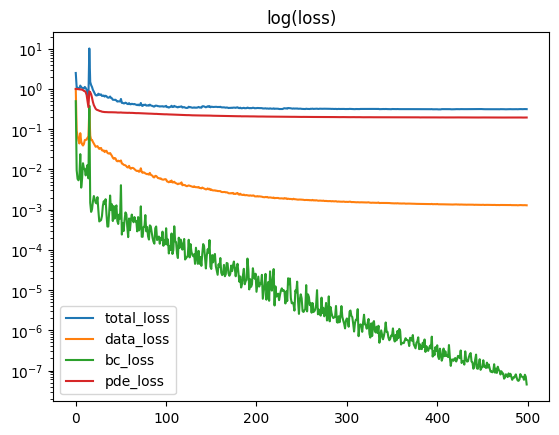

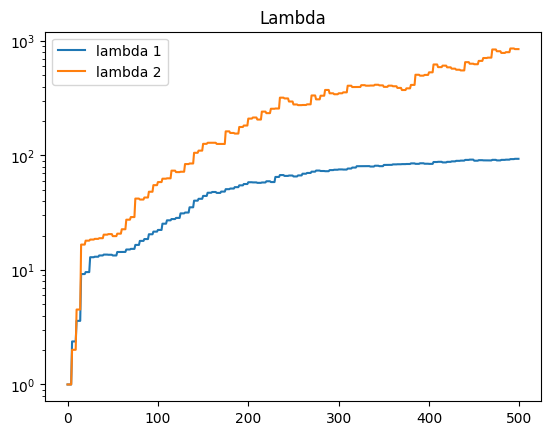

Evaluating on Train Set...
Train Set - Batch Mean Pressure Loss: 0.001267
Evaluating on Test Set...
Test Set - Batch Mean Pressure Loss: 0.001978


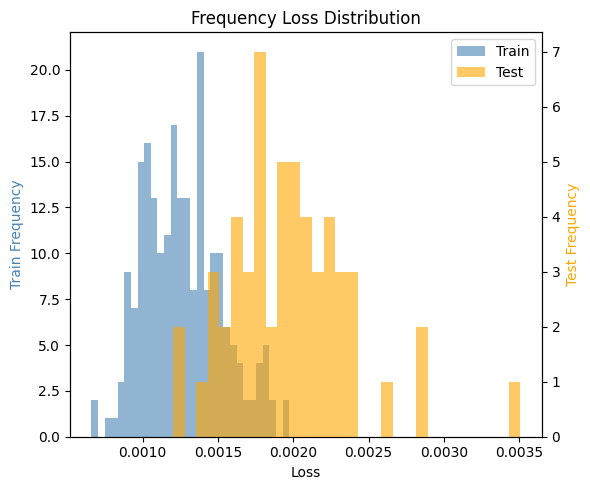

In [10]:
PINNs_model.plot_loss()
PINNs_model.plot_lambda()
train_errors, test_errors = PINNs_model.get_evaluate()

RMSE P = 0.019530683755874634 MAE P = 1.2952017236500524e-10


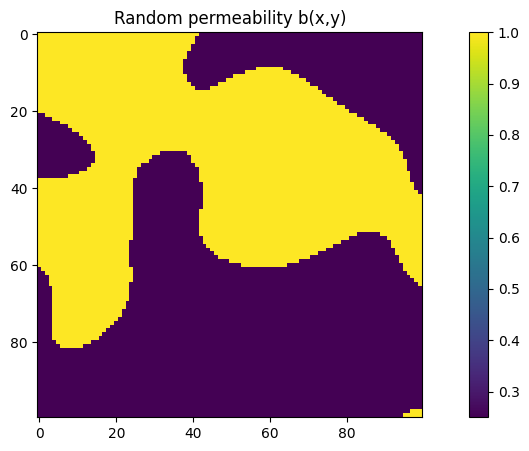

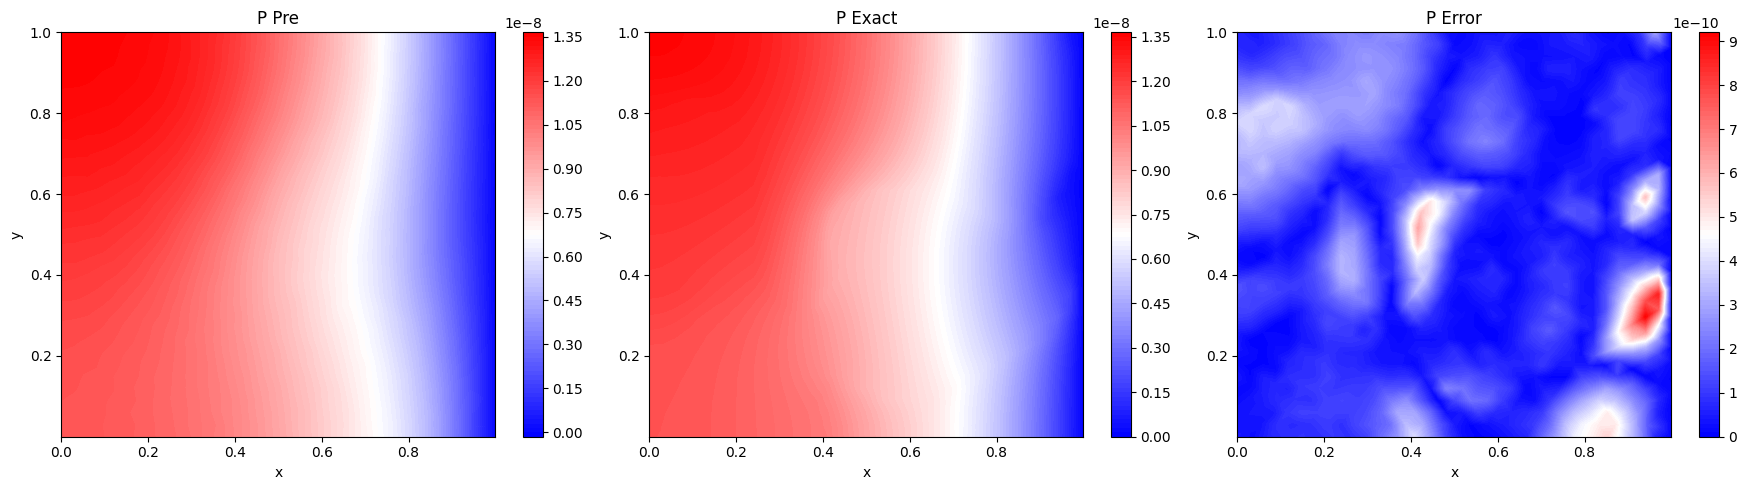

RMSE P = 0.018759634345769882 MAE P = 1.167001495439024e-10


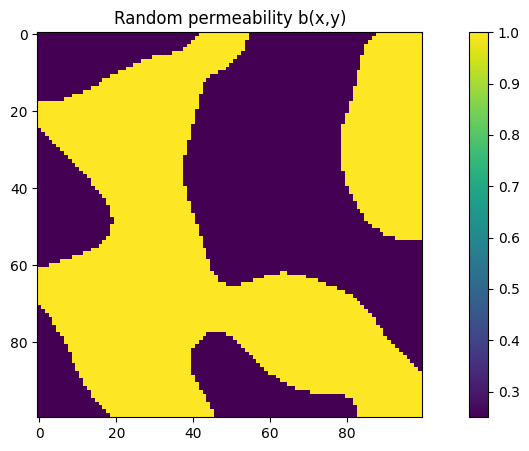

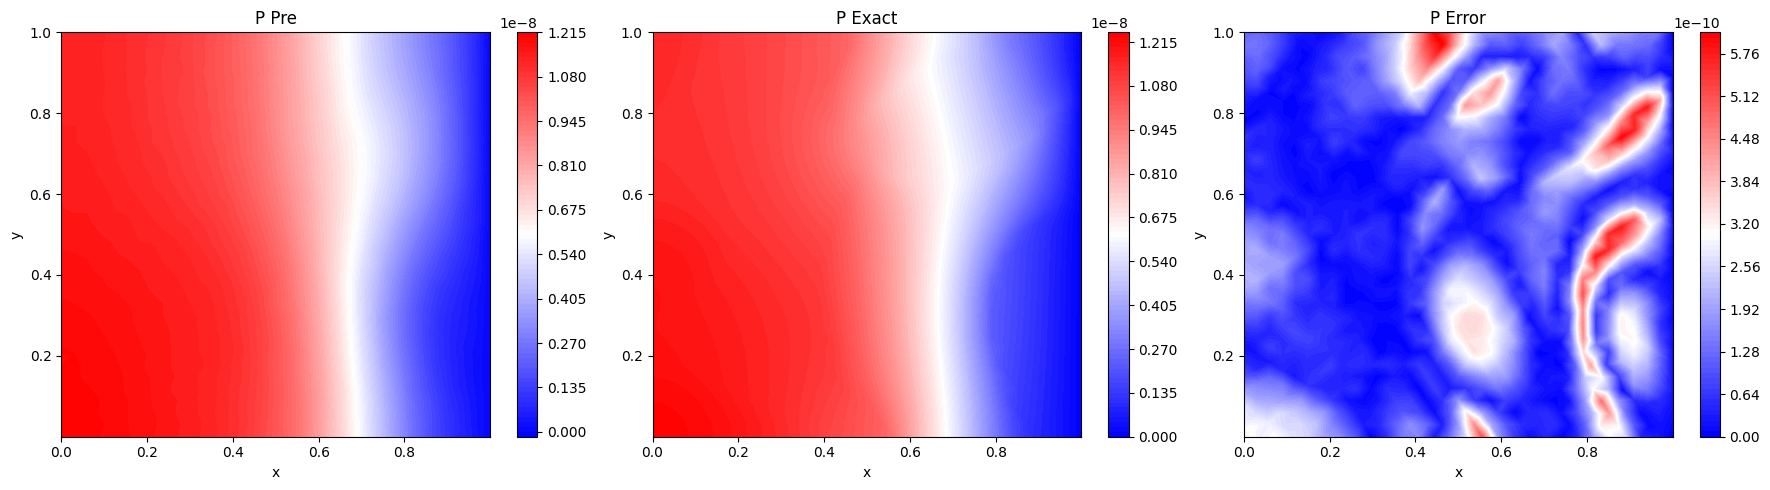

In [11]:
PINNs_model.plot_result(0)
PINNs_model.plot_result(1)